# The Exploration of Latents of MODIS L2
## Date: 3/24/2021


In [1]:
%matplotlib inline

from importlib import reload
import os
import numpy as np

import pandas

import h5py
import seaborn as sns
import pandas as pd

from ulmo.analysis import io as analy_io
from ulmo.utils import image_utils
from ulmo import plotting
from ulmo import io as ulmo_io
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
from tqdm import trange

In [2]:
reload(image_utils)

<module 'ulmo.utils.image_utils' from '/home/erdong/PycharmProjects/ulmo/ulmo/utils/image_utils.py'>

In [3]:
### Load the table
evals_path = '/home/erdong/ulmos/modis_l2/MODIS_L2_std.feather'
evals_tbl = ulmo_io.load_main_table(evals_path)

Read main table: /home/erdong/ulmos/modis_l2/MODIS_L2_std.feather


In [4]:
### Check if there exist any 'NaN' values
print(evals_tbl.isna().sum())

lat                      0
lon                      0
col                      0
datetime                 0
LL                  135712
row                      0
clear_fraction           0
mean_temperature         0
Tmin                     0
Tmax                     0
T90                      0
T10                      0
filename                 0
UID                      0
pp_file                  0
pp_root                  0
field_size               0
pp_type                  0
pp_idx                   0
dtype: int64


In [5]:
### Quick try: drop the 'NaN' points
evals_tbl_drop = evals_tbl.dropna()
print(evals_tbl_drop.isna().sum())

lat                 0
lon                 0
col                 0
datetime            0
LL                  0
row                 0
clear_fraction      0
mean_temperature    0
Tmin                0
Tmax                0
T90                 0
T10                 0
filename            0
UID                 0
pp_file             0
pp_root             0
field_size          0
pp_type             0
pp_idx              0
dtype: int64


In [6]:
# Add in DT
if 'DT' not in evals_tbl.keys():
    evals_tbl_drop['DT'] = evals_tbl.T90 - evals_tbl.T10

<ipython-input-6-44a31c3606f3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evals_tbl_drop['DT'] = evals_tbl.T90 - evals_tbl.T10


In [7]:
in_brazil = ((np.abs(evals_tbl_drop.lon.values + 57.5) < 10.)  &
    (np.abs(evals_tbl_drop.lat.values + 43.0) < 10))
in_DT = np.abs(evals_tbl_drop.DT - 2.05) < 0.05
evals_bz = evals_tbl_drop[in_brazil & in_DT].copy()

In [8]:
logL = evals_bz.LL.values

lowLL_val = np.percentile(logL, 10.)
hiLL_val = np.percentile(logL, 90.)

In [9]:
low = evals_bz.LL < lowLL_val
high = evals_bz.LL > hiLL_val

example = evals_bz[low].iloc[-1]
example

lat                                                        -38.458702
lon                                                        -54.815647
col                                                               645
datetime                                          2019-01-05 04:50:00
LL                                                        -254.304993
row                                                                16
clear_fraction                                               0.006042
mean_temperature                                            18.216663
Tmin                                                        16.369999
Tmax                                                           21.285
T90                                                         19.234999
T10                                                            17.205
filename                         AQUA_MODIS.20190105T045000.L2.SST.nc
UID                                                154651541312518435
pp_file             

In [10]:
### Show the example
# field, mask = image_utils.grab_modis_l2_img(example, 'PreProc', ptype='std')

In [11]:
### Load the latents file
lat_file = '/home/erdong/ulmos/modis_l2/' \
           'MODIS_R2019_2019_95clear_128x128_latents_std.h5'

l_h5 = h5py.File(lat_file, 'r')
latents = l_h5['latents']
latents.shape

(751689, 512)

In [12]:
### Show the statistics of several features of the latents
latents_part_df = pd.DataFrame(latents[:, :400])
latents_part_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751689 entries, 0 to 751688
Columns: 400 entries, 0 to 399
dtypes: float32(400)
memory usage: 1.1 GB


In [13]:
latents_part_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
count,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,...,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000,751689.000000
mean,0.004975,0.001060,-0.001625,0.007018,0.010252,-0.004330,-0.001359,-0.000082,-0.005402,0.000272,...,0.004499,-0.007422,-0.002398,0.004064,0.010843,0.002954,0.004194,0.000145,-0.011412,-0.006052
std,0.974134,0.983585,0.973872,0.983486,0.985401,0.987638,0.978905,0.982374,0.981341,0.979087,...,0.976848,0.985243,0.980718,0.981631,0.973597,0.979820,0.992822,0.982427,0.986249,0.984277
min,-12.895608,-11.473268,-8.643445,-12.344545,-11.076551,-11.799313,-12.563170,-14.518270,-11.212376,-10.744902,...,-9.777671,-9.955516,-12.292439,-12.638578,-15.550569,-12.391028,-13.237496,-13.111054,-13.853485,-12.878211
25%,-0.488145,-0.524477,-0.541840,-0.476032,-0.495000,-0.493991,-0.497078,-0.496550,-0.538741,-0.501030,...,-0.521854,-0.498464,-0.507808,-0.481324,-0.453612,-0.520528,-0.493105,-0.500887,-0.429397,-0.507753
50%,0.033400,0.002166,-0.038763,0.018280,0.000002,0.008190,0.000602,0.008204,-0.013831,0.020663,...,-0.008118,-0.026581,0.026821,0.004810,0.077684,0.022664,0.007105,0.007249,0.047447,-0.005162
75%,0.539309,0.532241,0.486545,0.512602,0.503973,0.494812,0.495949,0.507855,0.518780,0.522501,...,0.518684,0.478979,0.540610,0.485096,0.558634,0.548474,0.506308,0.503110,0.472975,0.498321
max,9.434946,9.087834,13.096346,9.850948,10.632300,10.975488,11.278859,10.691287,10.463519,12.954918,...,12.420573,10.999012,11.334339,10.844025,7.939140,9.157885,11.574175,10.978301,11.022414,11.049067


### From above descriptions, we know that all the features of the latents almost belong to the standard normal distribution.

<AxesSubplot:ylabel='Count'>

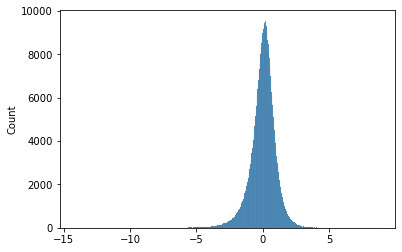

In [14]:
### We will plot the histogram of a randomly selected feature of the latents
seed = 0
np.random.seed(seed)
index_rand = np.random.randint(512)
sns.histplot(latents[:, index_rand])

### Let's do linear transformation to standarize the latent vector at first.
### For each component, we do $x_{std} = (x - \mu) / \sigma(x)$.

In [15]:
### Initialize the linear transformer at first
scaler = StandardScaler()
### Estimate the parameters
scaler.fit(latents)
### Transform the latents
latents_std = scaler.transform(latents)

In [17]:
### Let's use PCA at first to estimate the dimension of the main components. But before that, we want to standarize the latent vector
pca = PCA(n_components='mle', random_state=0)
pca.fit(latents_std)
singular_vals = pca.singular_values_

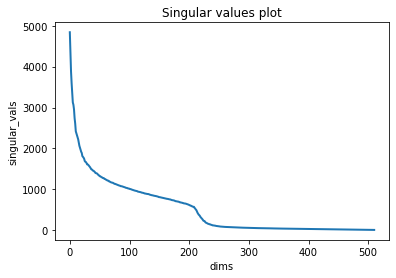

In [18]:
### plot the singular values to estimate the dimensions
plt.figure()
plt.title('Singular values plot')
plt.plot(singular_vals.squeeze(), linewidth=2)
plt.xlabel('dims')
plt.ylabel('singular_vals')
plt.show()

### From above plot, actually we can try to use the $dims = 300$ for the latent space.
### Here we use $dims = 256$.

In [19]:
pca = PCA(n_components=256, random_state=0)
pca.fit(latents_std)
latents_reduced = pca.transform(latents_std)
print(latents_reduced.shape)


(751689, 256)


In [20]:
### As a first try, let's try to use 'k-means' clustering.
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(latents_reduced)

KMeans(n_clusters=2, random_state=0)

<AxesSubplot:ylabel='Count'>

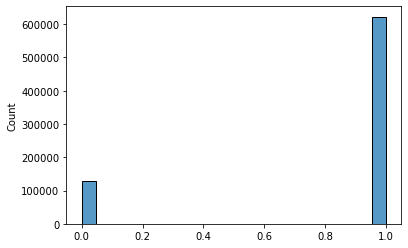

In [21]:
### Check the labels given by 'k-means'
sns.histplot(kmeans.labels_)

In [22]:
### Show the statistics of the 'clusters'
labels_df = pd.DataFrame(kmeans.labels_, columns=['predicted_label'])
labels_df.describe()

,predicted_label
count,751689.000000
mean,0.827969
std,0.377408
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


### From 'k-means', if we divide the data set into two groups, there are $82.8\%$ positive samples.
### But here we assume that there are $2$ clusters, actually we can explore the num of clusters.

In [23]:
###  color prepare
red_indices = np.argwhere(kmeans.labels_ == 1)
blue_indices = np.argwhere(kmeans.labels_ == 0)
#colors = [0] * kmeans.labels_.shape[0]
#colors[red_indices.squeeze()] = 'red'


Text(0.5, 1.0, 'Scatter plot of Reduced Latent Space')

/home/erdong/PycharmProjects/ulmo/venv_conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


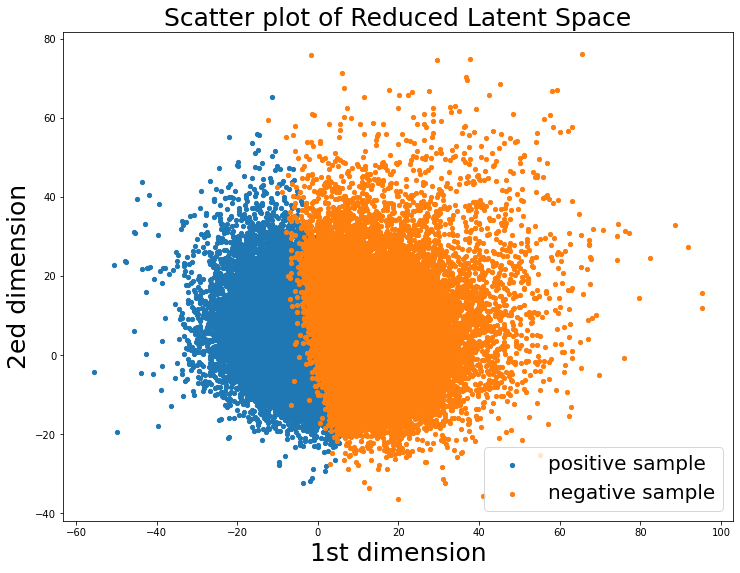

In [72]:
plt.figure(figsize=(12, 9))
plt.scatter(latents_reduced[:, 0][red_indices.squeeze()], latents_reduced[:, 1][red_indices.squeeze()],
            s=18, label='positive sample')
plt.scatter(latents_reduced[:, 0][blue_indices.squeeze()], latents_reduced[:, 1][blue_indices.squeeze()],
            s=18, label='negative sample')
plt.xlabel('1st dimension', fontsize=25)
plt.ylabel('2ed dimension', fontsize=25)
plt.legend(fontsize=20)
plt.title('Scatter plot of Reduced Latent Space', fontsize=25)

### Studying the number of clusters as hyper-parameter

In [25]:
### We study the inertia of the k-means with different number of clusters.
inertia_list = []
for n_clusters in trange(2, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(latents_reduced)
    inertia_list.append(kmeans.inertia_)

100%|██████████| 8/8 [10:29<00:00, 78.70s/it] 


In [26]:
### Save the 'inertia_list'
inertia_df = pd.DataFrame(inertia_list, columns=['inertia'])
inertia_path = './inertia.csv'
inertia_csv = inertia_df.to_csv(inertia_path, index=False)

Text(0.5, 1.0, 'Study of num of clusters')

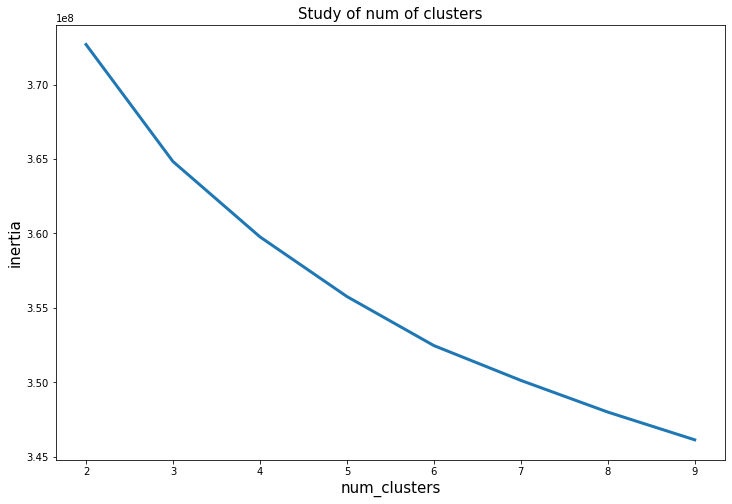

In [32]:
### Plot the 'inertia' vs 'num_clusters'
plt.figure(figsize=(12, 8))
num_clusters = list(range(2, 10))
plt.plot(num_clusters, inertia_list, linewidth=3)
plt.xlabel('num_clusters', fontsize=15)
plt.ylabel('inertia', fontsize=15)
plt.title('Study of num of clusters', fontsize=15)

### Show the scatter plot of the k-means with different number of clusters

In [55]:
### We show the k-means with $9$ clusters
### Show the histogram at first
labels_df = pd.DataFrame(kmeans.labels_, dtype='category', columns=['cluster_id'])
labels_df.describe()
labels_df.iloc[1]
#labels_df.astype(dtype='category')
#labels_df
#sns.histplot(kmeans.labels_)

cluster_id    1
Name: 1, dtype: category
Categories (9, int64): [0, 1, 2, 3, ..., 5, 6, 7, 8]

In [62]:
labels_df.groupby('cluster_id')['cluster_id'].describe()

,count,unique,top,freq
cluster_id,,,,
0,43767,1,0,43767
1,283239,1,1,283239
2,24952,1,2,24952
3,35082,1,3,35082
4,175425,1,4,175425
5,80317,1,5,80317
6,79512,1,6,79512
7,9380,1,7,9380
8,20015,1,8,20015


### From above summary, we find that the smallest group is 'cluster_8', the biggest group is 'cluster 2'.
### So let's plot the scatter of cluster '2' and '8'.

Text(0.5, 1.0, 'Scatter plot of 2 clusters')

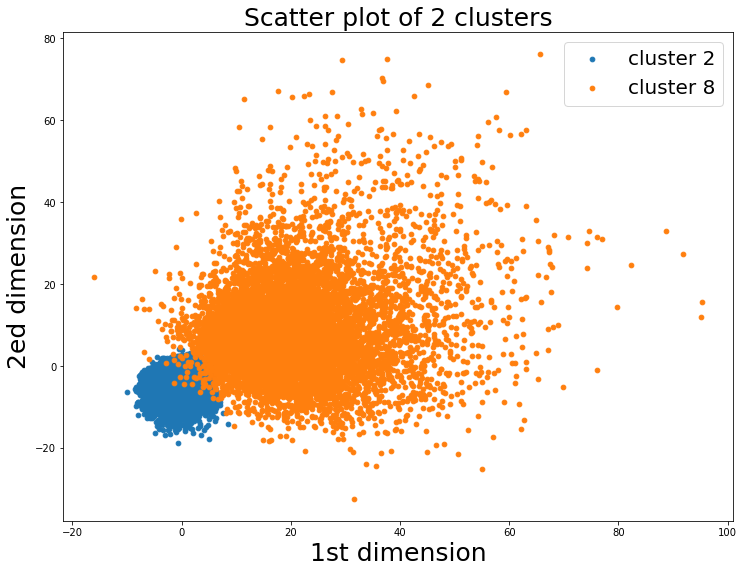

In [77]:
### Scatter plot
id2_indices = np.argwhere(kmeans.labels_ == 1)
id8_indices = np.argwhere(kmeans.labels_ == 7)

plt.figure(figsize=(12, 9))
plt.scatter(latents_reduced[:, 0][id2_indices.squeeze()], latents_reduced[:, 1][id2_indices.squeeze()],
            s=22, label='cluster 2')
plt.scatter(latents_reduced[:, 0][id8_indices.squeeze()], latents_reduced[:, 1][id8_indices.squeeze()],
            s=22, label='cluster 8')
plt.xlabel('1st dimension', fontsize=25)
plt.ylabel('2ed dimension', fontsize=25)
plt.legend(fontsize=20)
plt.title('Scatter plot of 2 clusters', fontsize=25)

Text(0.5, 1.0, 'Scatter plot of 3 clusters')

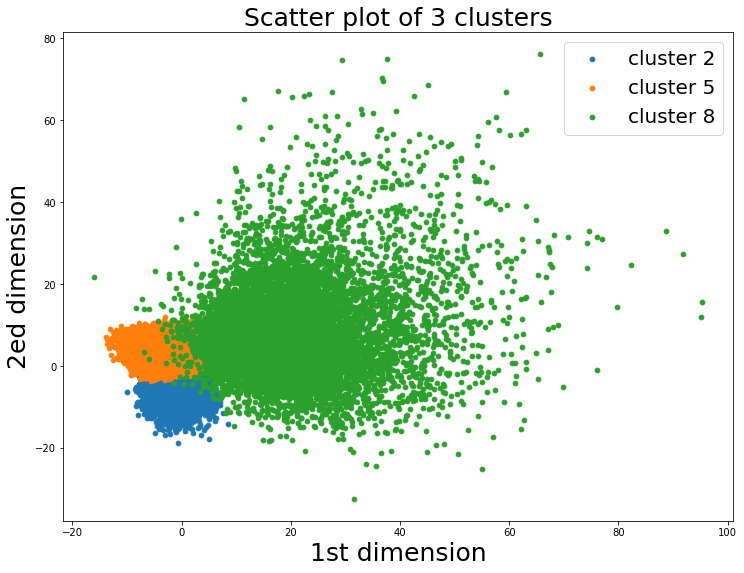

In [78]:
### Scatter plot of three clusters 'cluster 2', 'cluster 5' and 'cluster 8'.
id2_indices = np.argwhere(kmeans.labels_ == 1)
id5_indices = np.argwhere(kmeans.labels_ == 4)
id8_indices = np.argwhere(kmeans.labels_ == 7)

plt.figure(figsize=(12, 9))
plt.scatter(latents_reduced[:, 0][id2_indices.squeeze()], latents_reduced[:, 1][id2_indices.squeeze()],
            s=22, label='cluster 2')
plt.scatter(latents_reduced[:, 0][id5_indices.squeeze()], latents_reduced[:, 1][id5_indices.squeeze()],
            s=22, label='cluster 5')
plt.scatter(latents_reduced[:, 0][id8_indices.squeeze()], latents_reduced[:, 1][id8_indices.squeeze()],
            s=22, label='cluster 8')
plt.xlabel('1st dimension', fontsize=25)
plt.ylabel('2ed dimension', fontsize=25)
plt.legend(fontsize=20)
plt.title('Scatter plot of 3 clusters', fontsize=25)


Text(0.5, 1.0, 'Scatter plot of 10 clusters')

/home/erdong/PycharmProjects/ulmo/venv_conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


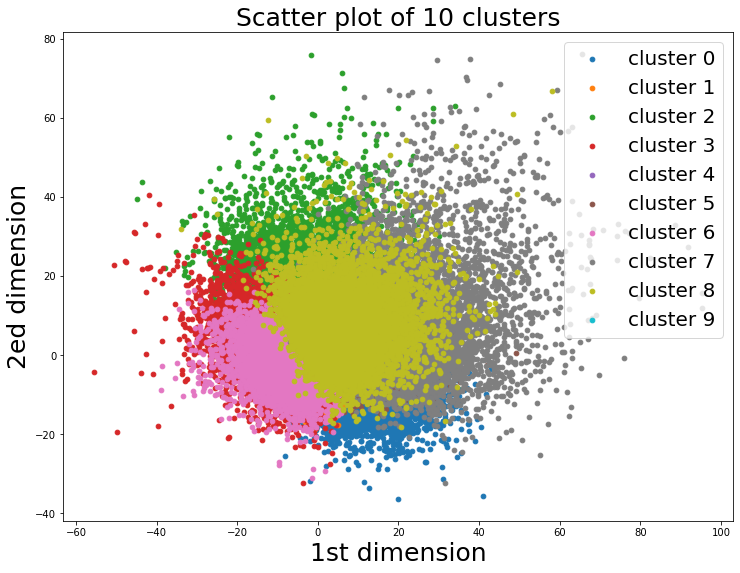

In [80]:
### Scatter plot of all clusters
plt.figure(figsize=(12, 9))
for k in range(10):
    idk_indices = np.argwhere(kmeans.labels_==k)
    plt.scatter(latents_reduced[:, 0][idk_indices.squeeze()], latents_reduced[:, 1][idk_indices.squeeze()],
                s=22, label=f'cluster {k}')
plt.xlabel('1st dimension', fontsize=25)
plt.ylabel('2ed dimension', fontsize=25)
plt.legend(fontsize=20)
plt.title('Scatter plot of 10 clusters', fontsize=25)